In [47]:
import osmnx as ox
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from tqdm import tqdm

# Checking our Results

In this notebook we will try to see how the distances we obtained look like on the map of the FUA.

## 1. Getting the files

Known issue: the OD matrices have two extra columns (unnamed 0 and unnamed 0.1) due to droping indices while saving along the way. i will fix this later but for now we can just drop the columns as we load the matrices

In [4]:
def get_files(fua_code):
    
    buffered_boundary = gpd.read_file('../data/d03_intermediate/FUA-buffered-shapefile/FUA-buffered.shp').set_index('fuacode').loc[[fua_code]]
    walk_graph = ox.load_graphml('../data/d03_intermediate/FUA-networks/walk/'+fua_code+'.graphml')
    drive_graph = ox.load_graphml('../data/d03_intermediate/FUA-networks/drive/'+fua_code+'.graphml')
    OD_matrix = pd.read_csv('../data/d04_final-OD-matrices/'+fua_code+'_ODmatrix.csv').drop(['Unnamed: 0'], axis=1)
    
    return buffered_boundary, walk_graph, drive_graph, OD_matrix

 We will use two functional urban areas as example: FUA80 and FUA81.

In [5]:
buffered_boundary_80, walk_graph_80, drive_graph_80, OD_matrix_80 = get_files('USA80')
buffered_boundary_81, walk_graph_81, drive_graph_81, OD_matrix_81 = get_files('USA81')

And for Boston:

In [14]:
buffered_boundary_boston, walk_graph_boston, drive_graph_boston, OD_matrix_boston = get_files('USA11')

These OD matrices will have columns telling us whether the commute was made by walking or driving (note that we concatatenated the datafames of walking and driving vertically so that all the driving come first), columns with the OSMid of the closest node in the correponding network, and the distance in meters

In [15]:
OD_matrix_boston.head()

,safegraph_place_id,census_block_group,top_category,latitude,longitude,fuacode,intptlat,intptlon,mode,origin_node,origin_node_dist,destination_node,destination_node_dist,distance
0,sg:00003112338041738d01a3e3bb13ea68,250173353022,Religious Organizations,42.566885,-70.934055,USA11,42.505953,-71.050532,drive,69023280,94.781506,65586646,43.107231,14291.359
1,sg:00003112338041738d01a3e3bb13ea68,250092176001,Religious Organizations,42.566885,-70.934055,USA11,42.585500,-70.838971,drive,69503804,111.915891,65586646,43.107231,8918.639
2,sg:00003112338041738d01a3e3bb13ea68,250092114011,Religious Organizations,42.566885,-70.934055,USA11,42.577186,-70.981716,drive,65537193,173.649933,65586646,43.107231,6013.509
3,sg:00003112338041738d01a3e3bb13ea68,250092121002,Religious Organizations,42.566885,-70.934055,USA11,42.600718,-71.030823,drive,67147928,91.574077,65586646,43.107231,9787.074
4,sg:00003112338041738d01a3e3bb13ea68,250092109002,Religious Organizations,42.566885,-70.934055,USA11,42.538739,-70.921963,drive,70476252,50.653831,65586646,43.107231,4105.689


The two networks occupy the same boundary, but are strikingly different in density and capillarity (there are many often more walking paths, and those are also always bidirectional)

In [ ]:
fig, Axes = plt.subplots(figsize=(40,20), ncols=2)

ax1 = buffered_boundary_boston.plot(ax=Axes[0])
ax1 = ox.plot_graph(walk_graph_boston, ax=ax1, close=False, show=False)[1]
ax1.title.set_text('Walking Network')

ax2 = buffered_boundary_boston.plot(ax=Axes[1])
ax2 = ox.plot_graph(drive_graph_boston, ax=ax2, close=False, show=False)[1]
ax2.title.set_text('Driving Network')

plt.show()

## 2. Looking at the Distances:

Some matrices have nan values. These values occured due to OSMNx not finding a route i.e. the closest node to the POI lies on an isolated node in the directional network. There were also some missed rows because we clipped the matrix.

In [40]:
with open('../data/d02_processed-safegraph/safegraph_fua.txt') as f:
    lines = f.readlines()
fua_codes = [code.strip('\n') for code in lines[::-1]]

Let's get a summary dataframe of our results performance:

In [46]:
full_od_matrix = pd.read_csv('../data/d02_processed-safegraph/weeks_od_us_fua.csv')
print('There are', len(full_od_matrix), 'rows in the dataset')

There are 19307834 rows in the dataset


In [69]:
data_summary = {'fuacode':[], 'total_rows':[], 'clipped_rows':[], 'null_rows':[]}
for fua in tqdm(fua_codes):
    #Add the FUA code:
    data_summary['fuacode'].append(fua)
    
    #Add the original number of rows:
    total_rows = len(full_od_matrix[full_od_matrix['fuacode']==fua])
    data_summary['total_rows'].append(total_rows)
    
    #Load the computed distance matrix:
    fua_OD_matrix = pd.read_csv('../data/d04_final-OD-matrices/'+fua+'_ODmatrix.csv').drop(['Unnamed: 0'], axis=1)
    
    #Add the clipped number of rows:
    total_OD_rows = len(fua_OD_matrix)
    data_summary['clipped_rows'].append(total_rows-total_OD_rows)
    
    #Add the null number of rows:
    null_rows = len(fua_OD_matrix[fua_OD_matrix['distance'].isnull()])
    data_summary['null_rows'].append(null_rows)

summary_df = pd.DataFrame.from_dict(data_summary).set_index('fuacode')

100%|████████████████████████████| 162/162 [04:07<00:00,  1.53s/it]


In [70]:
summary_df['lost_rows'] = summary_df['clipped_rows']+summary_df['null_rows']

summary_df['percent_clipped_rows'] = 100*summary_df['clipped_rows']/summary_df['total_rows']
summary_df['percent_null_rows'] = 100*summary_df['null_rows']/(summary_df['total_rows']-summary_df['clipped_rows'])
summary_df['percent_lost_rows'] = 100*summary_df['lost_rows']/summary_df['total_rows']

In [71]:
summary_df.head()

,total_rows,clipped_rows,null_rows,lost_rows,percent_clipped_rows,percent_null_rows,percent_lost_rows
fuacode,,,,,,,
USA01,2179673,6017,4479,10496,0.276051,0.206058,0.481540
USA02,1618896,4135,8643,12778,0.255421,0.535249,0.789303
USA03,837349,2809,3919,6728,0.335463,0.469600,0.803488
USA04,731260,3150,3913,7063,0.430763,0.537419,0.965867
USA05,550234,4849,2733,7582,0.881261,0.501114,1.377959


In [72]:
summary_df.to_csv('../data/d04_final-OD-matrices/summary.csv')

array([[<AxesSubplot:title={'center':'percent_clipped_rows'}>]],
      dtype=object)

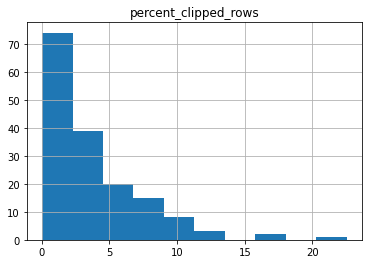

In [73]:
summary_df.hist('percent_clipped_rows')

In [75]:
print('In total, ', 100*summary_df.sum()['clipped_rows']/summary_df.sum()['total_rows'], '% of the rows were clipped and ', 100*summary_df.sum()['lost_rows']/summary_df.sum()['total_rows'], ' were lost')

In total,  1.608077923607481 % of the rows were clipped and  2.0323150712977474  were lost


In [77]:
summary_df.sum()

total_rows              1.930783e+07
clipped_rows            3.104850e+05
null_rows               8.191100e+04
lost_rows               3.923960e+05
percent_clipped_rows    6.217307e+02
percent_null_rows       5.047067e+01
percent_lost_rows       6.703996e+02
dtype: float64